# Acknowledgements

- Dataset from https://github.com/ieee8023/covid-chestxray-dataset
- COVID-19 Detector code from https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !unzip -u "/content/drive/MyDrive/kaggle/chest-xray-pneumonia.zip" -d "/content/drive/MyDrive/kaggle/chest"

# Imports

In [ ]:
import pandas as pd
import os

In [ ]:
# General libraries
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

# Deep learning libraries
#import keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

#Util Component 1: Confusion matrix report/Accuracy measures
from sklearn.metrics import accuracy_score, confusion_matrix

# disabling warnings
import logging
logging.getLogger('tensorflow').disabled = True #Jordan_note: Disable red warning lines seen at model architecture creation.

# Utility Functions

In [ ]:
def renderConfusionMetrics ( ___model, _testData, _testLabels, enableTraining, ___train_gen, ___test_gen, __batch_size, __epochs, hdf5_testSaveFileName ):
    preds = ___model.predict(_testData)

    acc = accuracy_score(_testLabels, np.round(preds))*100
    cm = confusion_matrix(_testLabels, np.round(preds))
    tn, fp, fn, tp = cm.ravel()


    print('\nCONFUSION MATRIX FORMAT ------------------\n')
    print("[true positives    false positives]")
    print("[false negatives    true negatives]\n\n")

    print('CONFUSION MATRIX ------------------')
    print(cm)

    print('\nTEST METRICS ----------------------')
    precision = tp/(tp+fp)*100
    recall = tp/(tp+fn)*100
    specificity = tn/(tn+fp)*100 #Jordan_note: added specificity calculation 
    print('Accuracy: {}%'.format(acc))
    print('Precision: {}%'.format(precision))
    print('Recall/Sensitivity: {}%'.format(recall)) #Jordan_note: added sensitivity label
    print('Specificity {}%'.format(specificity)) #Jordan_note: added specificity calculation 
    print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


    if enableTraining:
        checkpoint = ModelCheckpoint(filepath=hdf5_testSaveFileName, save_best_only=True, save_weights_only=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


        hist = ___model.fit_generator(
                   ___train_gen, steps_per_epoch=___test_gen.samples // __batch_size, 
                   epochs=__epochs, validation_data=___test_gen, 
                   validation_steps=___test_gen.samples // __batch_size, callbacks=[checkpoint, lr_reduce])

        print('\nTRAIN METRIC ----------------------')
        print('Covid19 Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    plt.savefig('train_val_acc_loss.png')

In [ ]:
#Util Component 2:model architecture description
def defineModelArchitecture (_img_dims ):
    # Input layer
    inputs = Input(shape=(_img_dims, _img_dims, 3))

    # First conv block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Second conv block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Third conv block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Fourth conv block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # Fifth conv block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.7)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    # Output layer
    output = Dense(units=1, activation='sigmoid')(x)
    
    return inputs, output


###########
#Util Component 3: Data processor
#Note: This process does not use validation path, because validation path in the original competion reasonably had too little data (8 samples) to create any insight.
# the "directoryProcessArray" param from "reportFileDistributions" function corresponds to the hard-coded sub-directories of train and test, excluding val.
def process_data(___inputPath, img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=___inputPath+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=___inputPath+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(___inputPath + 'test' + cond)):
            img = cv2.imread(___inputPath+'test'+cond+img,0) #Replace plt.imread, with  gray scale cv2.imread(path,0), so that ui's image load process doesn't throw a pyimage10 error
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels
    

###########
#Util Component 4: Report file distributions
#directoryProcessArray eg, = ['train', 'val', 'test'], in the case that training val and test folders exist in sub-dir for processing.
def reportFileDistributions (___inputPath, directoryProcessArray):
    for _set in directoryProcessArray:
        n_normal = len(os.listdir(___inputPath + _set + '/NORMAL'))
        n_infect = len(os.listdir(___inputPath + _set + '/PNEUMONIA'))
        print('Set: {}, normal images: {}, regular pneumonia images: {}'.format(_set, n_normal, n_infect))

In [ ]:
# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Hyperparameters
img_dims = 150
batch_size = 32

In [ ]:
inputs, output = defineModelArchitecture ( img_dims )

# Non-COVID-19 Lung Pneumonia Detection

In [ ]:
# Creating model and compiling
model_pneumoniaDetector = Model(inputs=inputs, outputs=output)
model_pneumoniaDetector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_pneumoniaDetector.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128   

In [ ]:
input_path_b = '/content/drive/MyDrive/kaggle/chest/chest_xray/chest_xray/'

In [ ]:
# Report file distributions
reportFileDistributions (input_path_b, ['train', 'val', 'test'] )

Set: train, normal images: 1342, regular pneumonia images: 3876
Set: val, normal images: 9, regular pneumonia images: 9
Set: test, normal images: 234, regular pneumonia images: 390


In [ ]:
# Getting the data
train_gen, test_gen, test_data_b, test_labels_b = process_data(input_path_b, img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.



CONFUSION MATRIX FORMAT ------------------

[true positives    false positives]
[false negatives    true negatives]


CONFUSION MATRIX ------------------
[[234   0]
 [390   0]]

TEST METRICS ----------------------
Accuracy: 37.5%
Precision: nan%
Recall/Sensitivity: 0.0%
Specificity 100.0%
F1-score: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
19/19 [==============================] - 164s 9s/step - loss: 0.6383 - accuracy: 0.7386 - val_loss: 0.6647 - val_accuracy: 0.6250
Epoch 2/10
19/19 [==============================] - 147s 8s/step - loss: 0.5234 - accuracy: 0.7362 - val_loss: 0.6728 - val_accuracy: 0.6217
Epoch 3/10
19/19 [==============================] - 124s 7s/step - loss: 0.3759 - accuracy: 0.7840 - val_loss: 0.7164 - val_accuracy: 0.6250
Epoch 4/10
19/19 [==============================] - 119s 6s/step - loss: 0.3225 - accuracy: 0.8393 - val_loss: 0.7529 - val_accuracy: 0.6283
Epoch 5/10
19/19 [==============================] - 116s 6s/step - loss: 0.3871 - accuracy: 0.8389 - val_loss: 1.0082 - val_accuracy: 0.6250
Epoch 6/10
19/19 [==============================] - 111s 6s/step - loss: 0.3186 - accuracy: 0.8504 - val_loss: 0.7299 - val_accuracy: 0.6283
Epoch 7/10
19/19 [==============================] - 96s 5s/step - loss: 0.3398 - accuracy: 0.8660 - val_loss: 0.6839 - val_accuracy: 0.6234

Epoch 00007: 

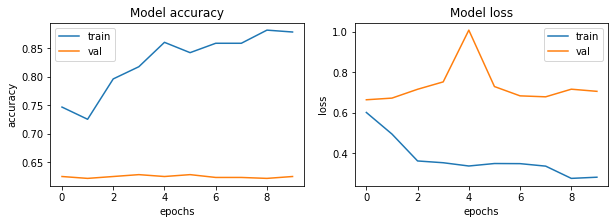

In [ ]:
renderConfusionMetrics(model_pneumoniaDetector, test_data_b, test_labels_b, True, train_gen, test_gen, batch_size, 10, 'model_weights.hdf5')


# COVID-19 Lung Pneumonia Detection

In [ ]:
inputs, output = defineModelArchitecture(img_dims)

# Creating model and compiling
model_covid19PneumoniaDetector = Model(inputs=inputs, outputs=output)
model_covid19PneumoniaDetector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_covid19PneumoniaDetector.load_weights('model_weights.hdf5')

In [ ]:
input_path_d = '/content/drive/MyDrive/kaggle/chest/chest_xray/'

In [ ]:
reportFileDistributions (input_path_d, ['train', 'test'])

Set: train, normal images: 1341, regular pneumonia images: 3875
Set: test, normal images: 234, regular pneumonia images: 390


In [ ]:
train_gen_d, test_gen_d, test_data_d, test_labels_d = process_data(input_path_d, img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.



CONFUSION MATRIX FORMAT ------------------

[true positives    false positives]
[false negatives    true negatives]


CONFUSION MATRIX ------------------
[[  0 234]
 [  0 390]]

TEST METRICS ----------------------
Accuracy: 62.5%
Precision: 62.5%
Recall/Sensitivity: 100.0%
Specificity 0.0%
F1-score: 76.92307692307692


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
19/19 [==============================] - 162s 8s/step - loss: 0.5334 - accuracy: 0.7165 - val_loss: 0.7270 - val_accuracy: 0.6184
Epoch 2/10
19/19 [==============================] - 159s 8s/step - loss: 0.3550 - accuracy: 0.7501 - val_loss: 0.8868 - val_accuracy: 0.6266
Epoch 3/10
19/19 [==============================] - 128s 7s/step - loss: 0.3640 - accuracy: 0.7793 - val_loss: 0.7809 - val_accuracy: 0.6250
Epoch 4/10
19/19 [==============================] - 113s 6s/step - loss: 0.2410 - accuracy: 0.9081 - val_loss: 0.8465 - val_accuracy: 0.6250

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
19/19 [==============================] - 111s 6s/step - loss: 0.3559 - accuracy: 0.8473 - val_loss: 0.7129 - val_accuracy: 0.6266
Epoch 6/10
19/19 [==============================] - 99s 5s/step - loss: 0.2522 - accuracy: 0.9054 - val_loss: 0.7781 - val_accuracy: 0.6184

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.00000042747706

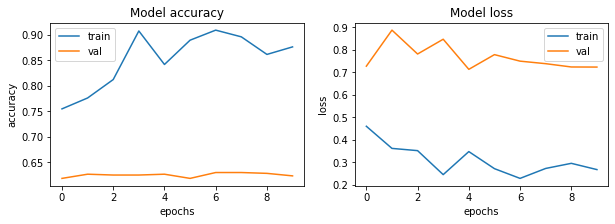

In [ ]:
renderConfusionMetrics(model_covid19PneumoniaDetector, test_data_d, test_labels_d, True, train_gen_d, test_gen_d, batch_size, 10, 'covid19_model_weights.hdf5')

In [ ]:
model_covid19PneumoniaDetector.save('model.h5')